In [7]:
# Import libraries

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.express as px

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_samples, silhouette_score

In [8]:
# Set notebook options

import warnings
warnings.filterwarnings("ignore")

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Import the data as a DataFrame and check first 5 rows

df = pd.read_csv('/content/drive/MyDrive/dataset/nbaPlayer.csv', index_col=0)

df.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,27,...,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,24,...,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,58,...,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,9,...,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,10,...,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97


In [11]:
categoricals = df.select_dtypes(exclude=[np.number])
categoricals.describe()

,player_name,team_abbreviation,college,country,draft_year,draft_round,draft_number,season
count,11145,11145,11145,11145,11145,11145,11145,11145
unique,2235,36,316,76,45,8,75,24
top,Vince Carter,TOR,None,USA,Undrafted,1,Undrafted,2017-18
freq,22,390,1684,9410,1942,6513,1959,540


In [13]:
# Create drafted column wiht boolean logic

df['drafted'] = np.where(df['draft_year'] != 'Undrafted', 1, 0)

In [14]:
# Convert draft_year column into a date type

# Replace Undrafted with NaN
df['draft_year'] = df['draft_year'].replace(r'Undrafted', np.nan, regex=True)

# Convert the column data type to date
df['draft_year'] = pd.to_datetime(df['draft_year'])

In [15]:
# Convert season column to an integer type

df['season'] = pd.to_datetime(df['season'].str[:4])

In [16]:
# Calculate heigh and weight averages

main_variables = df.groupby('player_name', as_index=False).agg({'player_height': 'mean', 'player_weight':'mean'})

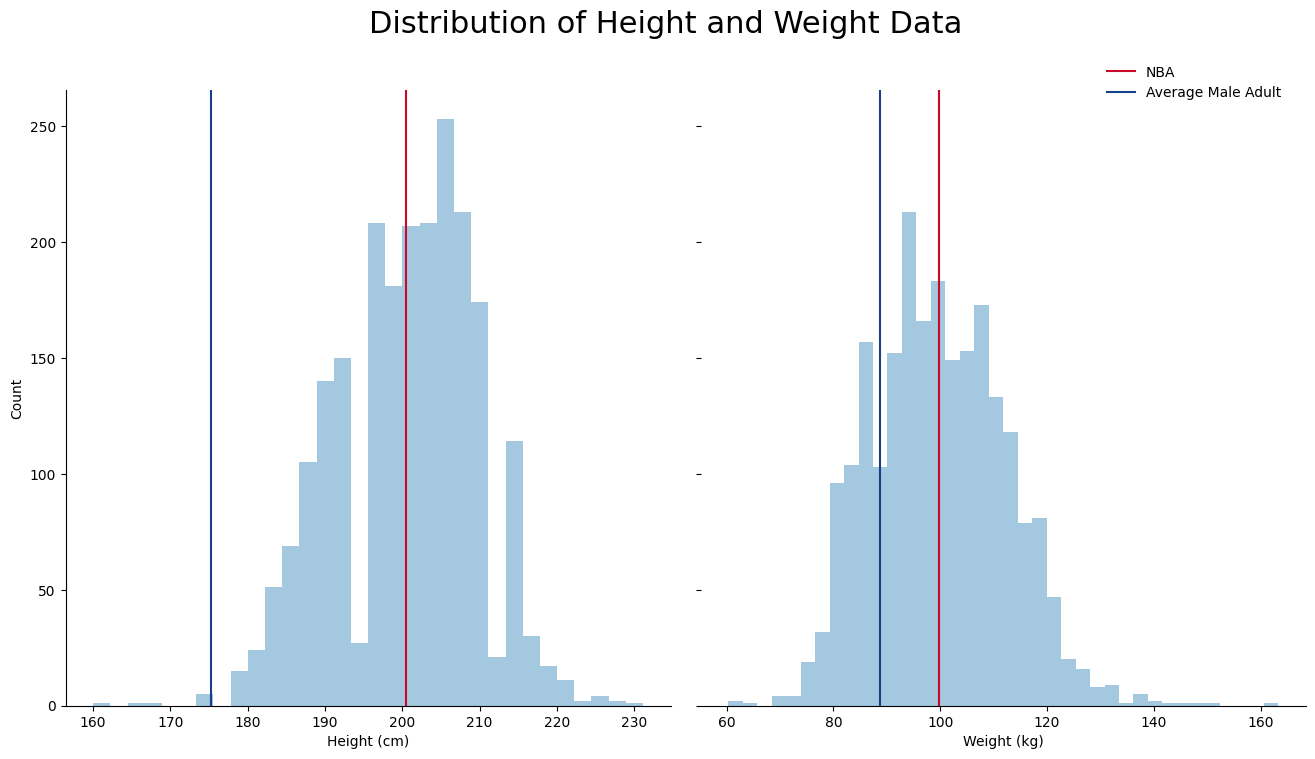

In [17]:
# 미국 성인 남성의 평균 신장과 NBA 선수의 신장 비교
# Source for average US male heigh: https://en.wikipedia.org/wiki/Average_human_height_by_country
# Source for average US male weight:https://en.wikipedia.org/wiki/Human_body_weight

fig, ax = plt.subplots(1,2,figsize=(16, 8),sharey=True)
plt.subplots_adjust(wspace=0.05)

sns.distplot(main_variables ['player_height'], ax=ax[0], label='_nolegend_', kde=False)
sns.distplot(main_variables ['player_weight'], ax=ax[1], label='_nolegend_', kde=False)
ax[0].axvline(main_variables ['player_height'].mean(), color='#c9082a', label='NBA')
ax[1].axvline(main_variables ['player_weight'].mean(), color='#c9082a', label='NBA')

# Add lines for average adults to compare
ax[0].axvline(175.3, color='#17408b', label='Average Male Adult')
ax[1].axvline(88.8, color='#17408b', label='Average Male Adult')

ax[0].yaxis.set_label_text('Count')
ax[0].xaxis.set_label_text('Height (cm)')
ax[1].xaxis.set_label_text('Weight (kg)')
plt.suptitle('Distribution of Height and Weight Data', fontsize=22)
plt.legend(loc='upper right', bbox_to_anchor=(0.98, 1.06), frameon=False)
sns.despine(ax=ax[1], left=True)
sns.despine(ax=ax[0])

plt.show()

In [18]:
fig = go.Figure(data=go.Scatter(x=main_variables['player_weight'],
                                y=main_variables['player_height'],
                                mode='markers',
                                text=main_variables['player_name'],
                                marker=dict(color='#17408b')
                                ))

fig.update_layout(
    title='NBA Player Height and Weight',
    xaxis_title='Weight (kg)',
    yaxis_title='Height (cm)'
)
fig.show()

In [20]:
corr = stats.pearsonr(main_variables['player_height'], main_variables['player_weight'])
corr_over_seasons = df.groupby('season')[['player_weight','player_height']].corr().unstack().iloc[:,1]

fig = go.Figure()
fig.add_trace(go.Scatter(x=corr_over_seasons.index,
                         y=corr_over_seasons.values,
                         mode='lines',
                         name='lines',
                         line=dict(color='#17408b')
                        ))

fig.update_layout(
    title='NBA Player Height and Weight Correlation Each Season',
    xaxis_title='Season',
    yaxis_title='Correlation',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

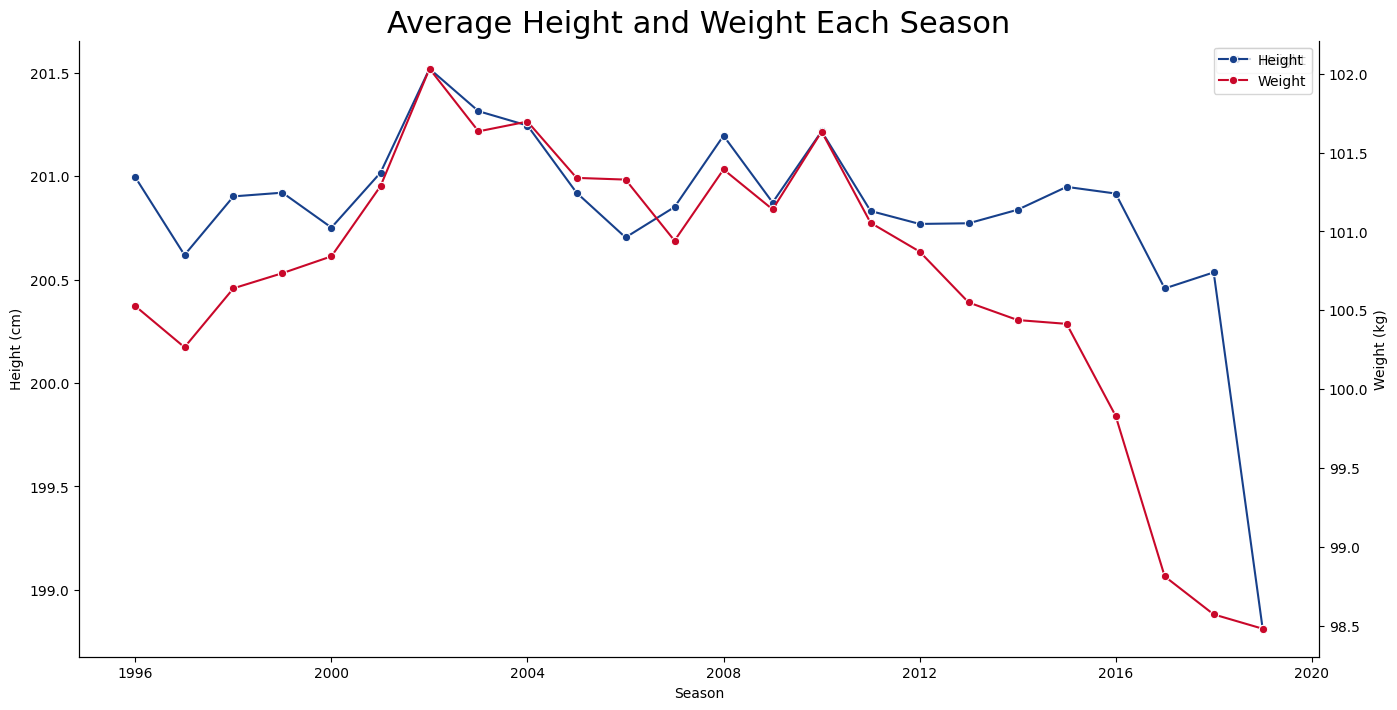

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))
ax2 = ax.twinx()

sns.lineplot(x=df['season'], y='player_height', data=df, marker="o", ax=ax, ci=None, label='Height', color='#17408b')
sns.lineplot(x=df['season'], y='player_weight', data=df, marker="o", ax=ax2, ci=None, label='Weight', color='#c9082a')

plt.title('Average Height and Weight Each Season', fontsize=22)
ax.xaxis.set_label_text('Season')
ax.yaxis.set_label_text('Height (cm)')
ax2.yaxis.set_label_text('Weight (kg)')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()

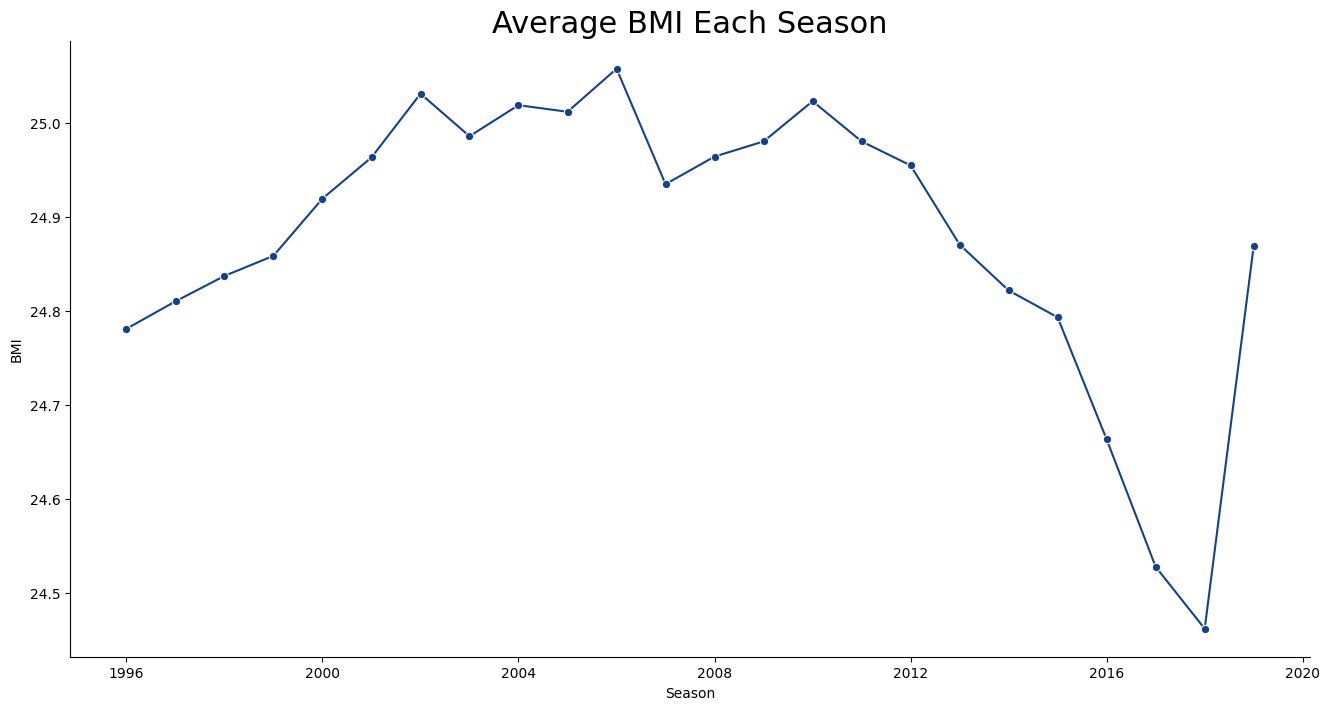

In [22]:
df['bmi'] = df['player_weight'].values / (df['player_height'].values ** 2) * 10000

plt.figure(figsize=(16, 8))

sns.lineplot(x=df['season'], y='bmi', data=df, marker="o", ci=None, color='#17408b')

plt.title('Average BMI Each Season', fontsize=22)
plt.ylabel('BMI')
plt.xlabel('Season')
sns.despine()

plt.show()

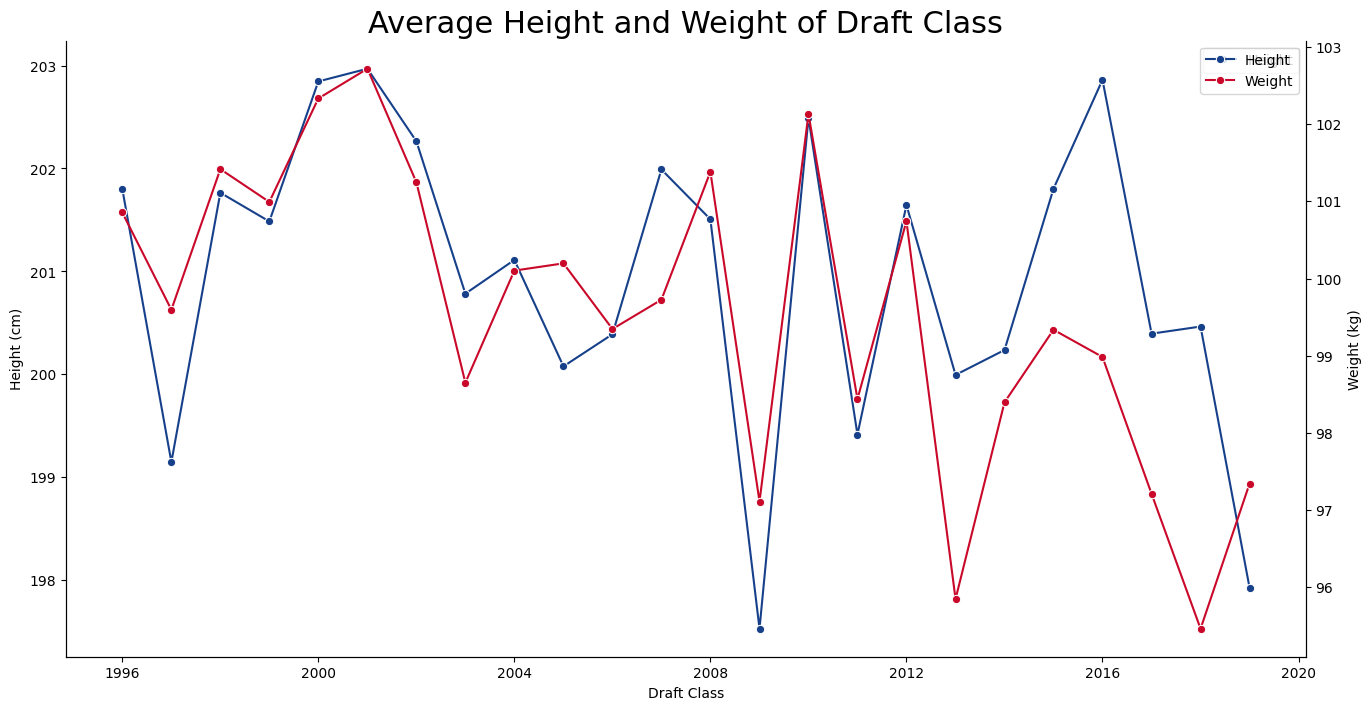

In [24]:
# Height and weight based on draft year

bmi_exploration = df[df['season'] == '2019']
bmi_exploration[['player_name','bmi']].sort_values(by='bmi',ascending=False)[:10]

first_season_drafted = df.query('season == draft_year')

h_w_by_draft_year = first_season_drafted.groupby('draft_year')['player_height', 'player_weight'].mean()

fig, ax = plt.subplots(figsize=(16, 8))
ax2 = ax.twinx()

sns.lineplot(x=h_w_by_draft_year.index, y='player_height', data=h_w_by_draft_year, marker="o", ax=ax, ci=None, label='Height', color='#17408b')
sns.lineplot(x=h_w_by_draft_year.index, y='player_weight', data=h_w_by_draft_year, marker="o", ax=ax2, ci=None, label='Weight', color='#c9082a')

plt.title('Average Height and Weight of Draft Class', fontsize=22)
ax.xaxis.set_label_text('Draft Class')
ax.yaxis.set_label_text('Height (cm)')
ax2.yaxis.set_label_text('Weight (kg)')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.show()


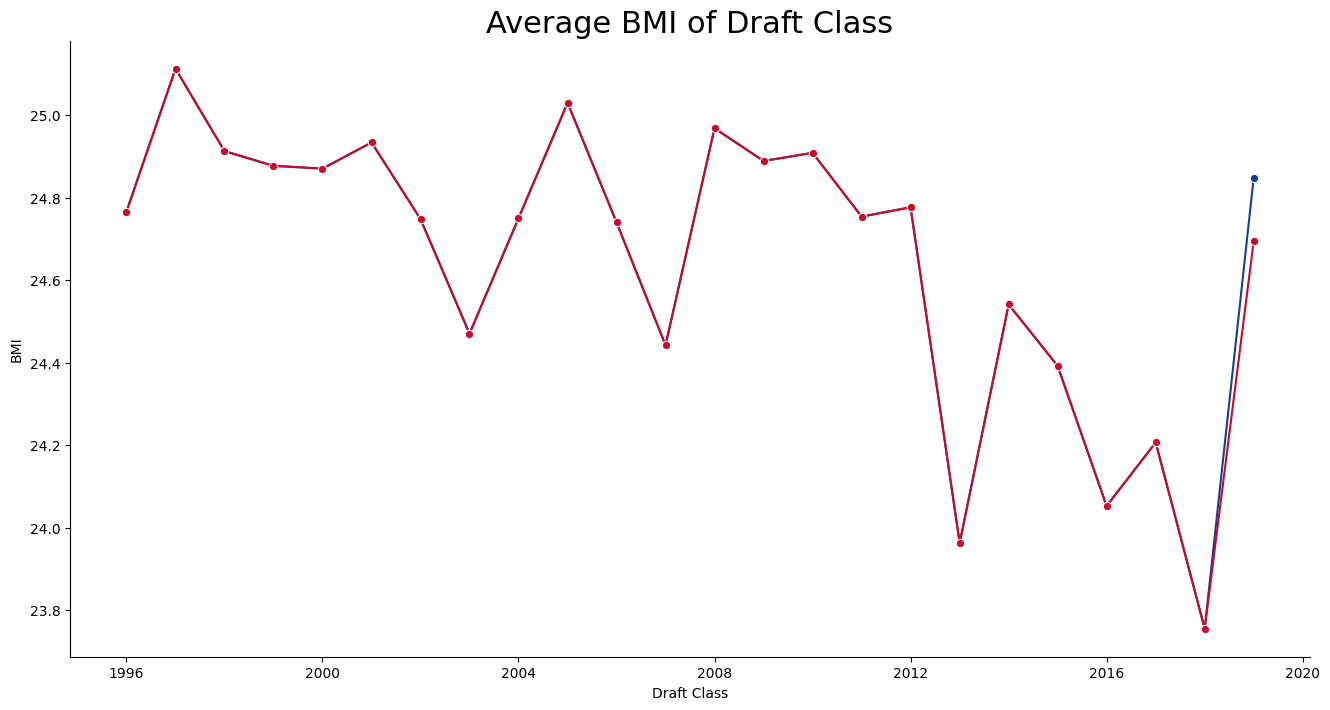

In [25]:
# BMI based on draft year

bmi_draft = h_w_by_draft_year['player_weight'] / (h_w_by_draft_year['player_height'] ** 2) * 10000
bmi_draft = pd.DataFrame(bmi_draft, columns=['bmi'])

first_season_drafted_nz = first_season_drafted[first_season_drafted['player_name'] != 'Zion Williamson']
h_w_by_draft_year_nz = first_season_drafted_nz.groupby('draft_year')['player_height', 'player_weight'].mean()
bmi_draft_nz = h_w_by_draft_year_nz['player_weight'] / (h_w_by_draft_year_nz['player_height'] ** 2) * 10000
bmi_draft_nz = pd.DataFrame(bmi_draft_nz, columns=['bmi'])

plt.figure(figsize=(16, 8))

sns.lineplot(x=bmi_draft.index, y=bmi_draft['bmi'], data=bmi_draft, marker="o", color='#17408b')
sns.lineplot(x=bmi_draft_nz.index, y=bmi_draft_nz['bmi'], data=bmi_draft, marker="o", color='#c9082a')

plt.title('Average BMI of Draft Class', fontsize=22)
plt.ylabel('BMI')
plt.xlabel('Draft Class')
sns.despine()

plt.show()

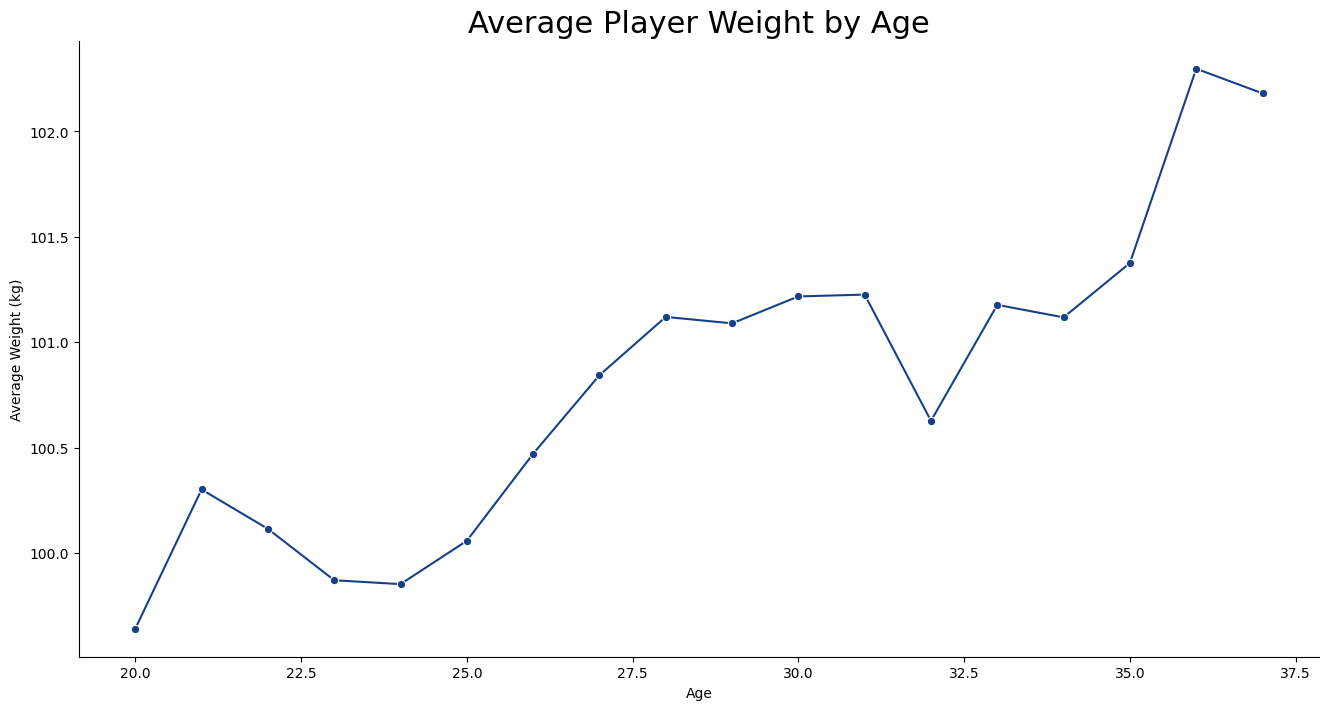

In [26]:
# Weight and player age

plt.figure(figsize=(16, 8))

w_by_age = df.groupby(['age'])['player_weight'].agg(['mean', 'count'])
w_by_age['outliers'] = np.where(w_by_age['count']<=100, 1, 0)
w_by_age = w_by_age.loc[w_by_age['outliers']==0]

sns.lineplot(x=w_by_age.index, y='mean', data=w_by_age, marker='o', color='#17408b')

plt.title('Average Player Weight by Age', fontsize=22)
plt.ylabel('Average Weight (kg)')
plt.xlabel('Age')
sns.despine()

plt.show()

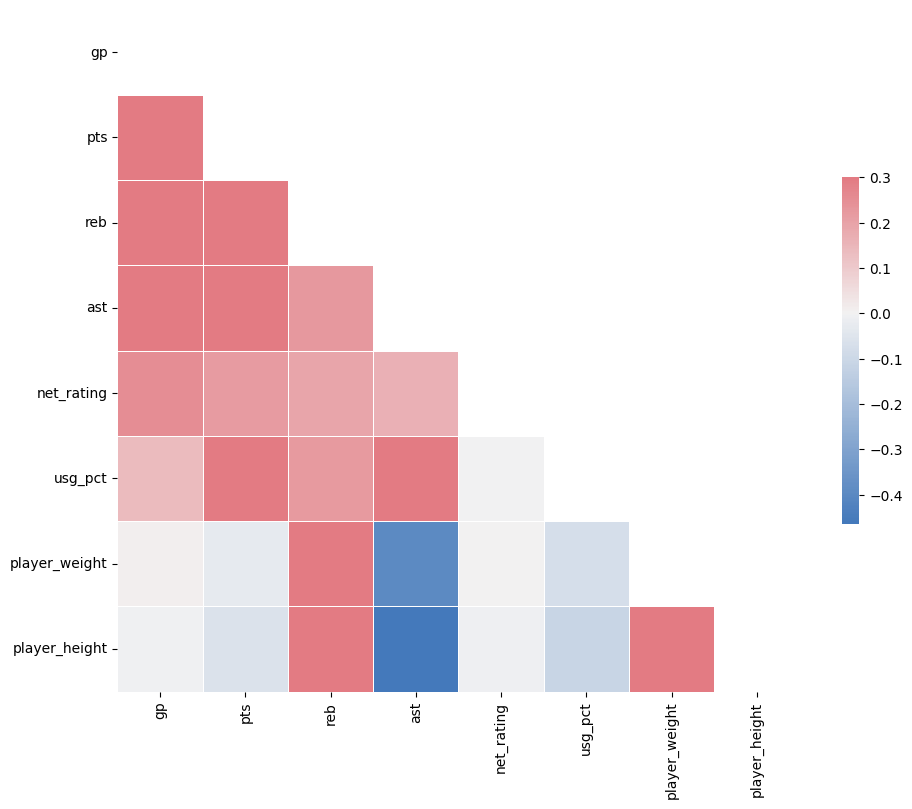

In [27]:
df_corr = df[df['season'] != '2019-01-01']
df_corr = df[['gp','pts','reb','ast','net_rating','usg_pct','player_weight', 'player_height']]

# Compute the correlation matrix
corr = df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

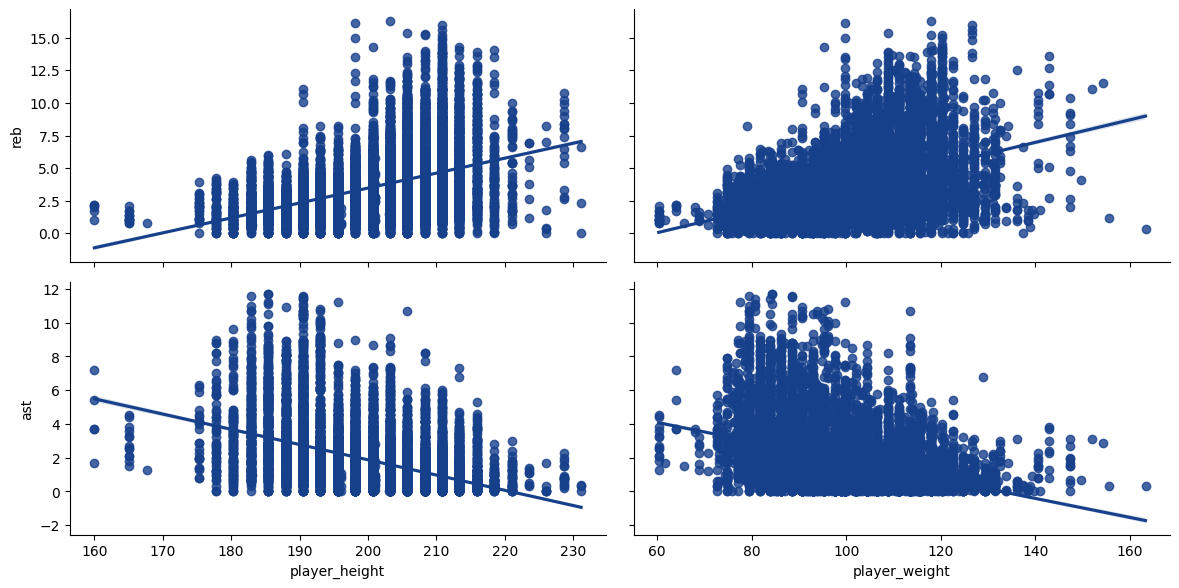

In [28]:
g = sns.PairGrid(df_corr, y_vars=['reb','ast'], x_vars=["player_height", "player_weight"], height=3, aspect=2)
g.map(sns.regplot, color='#17408b')
#g.set(ylim=(-1, 11), yticks=[0, 5, 10])
plt.show()

In [29]:
corr_w_r = df.groupby('season')[['player_weight','reb']].corr().unstack().iloc[:,1]
corr_w_a = df.groupby('season')[['player_weight','ast']].corr().unstack().iloc[:,1]

corr_h_r = df.groupby('season')[['player_height','reb']].corr().unstack().iloc[:,1]
corr_h_a = df.groupby('season')[['player_height','ast']].corr().unstack().iloc[:,1]

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=corr_w_r.index, y=corr_w_r.values,
                    mode='lines',
                    name='Weight and Rebounds'))

fig.add_trace(go.Scatter(x=corr_w_a.index, y=corr_w_a.values,
                    mode='lines',
                    name='Weight and Assists'))

fig.add_trace(go.Scatter(x=corr_h_r.index, y=corr_h_r.values,
                    mode='lines',
                    name='Height and Rebounds'))

fig.add_trace(go.Scatter(x=corr_h_a.index, y=corr_h_a.values,
                    mode='lines',
                    name='Height and Assists'))

fig.update_layout(
    title='Correlation Coefficient Comparison Over Time',
    xaxis_title='Season',
    yaxis_title='Coefficient',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.show()

In [40]:
df = df[df['net_rating'] < 40]
df = df[df['net_rating'] > -20]

df['height'] = pd.qcut(df['player_height'], q=6)
df['weight'] = pd.qcut(df['player_weight'], q=6)

In [41]:
fig = px.box(df.query('season > 2010'), y="net_rating", color="height")
fig.show()

In [36]:
fig = px.box(df.query('season < 2000'), y="net_rating", color="height")
fig.show()